In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

import datetime as dt
import sys

import numpy as np
import pandas as pd

from arch import arch_model
import arch.data.sp500

# Value-at-Risk
$$VaR_{t+1|t} = -\mu_{t+1|t} + \sigma_{t+1|t} q_{\alpha} $$
onde $\mu_{t+1|t}$ é a média condicional, $\sigma_{t+1|t}$ a volatilidade condicional e $q_{\alpha}$ é o $\alpha$ quantil com os standardized residuals, e.g., 5%.

In [3]:
data = arch.data.sp500.load()
market = data['Adj Close']
returns_old = 100 * market.pct_change()
returns = returns_old.dropna()

In [4]:
returns

Date
1999-01-05    1.358200
1999-01-06    2.214041
1999-01-07   -0.205133
1999-01-08    0.422136
1999-01-11   -0.879151
                ...   
2018-12-24   -2.711225
2018-12-26    4.959374
2018-12-27    0.856268
2018-12-28   -0.124158
2018-12-31    0.849248
Name: Adj Close, Length: 5030, dtype: float64

In [6]:
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='skewt')
res = am.fit(disp='off', last_obs='2017-12-31') #deixa o ultimo ano pra testar

# VaR paramétrico: assume-se uma distribuição para os valores

In [8]:
forecasts = res.forecast(start='2018-1-1')

In [14]:
cond_mean = forecasts.mean['2018' :] #pegando só a forecast de 2018
cond_mean

,h.1
Date,
2018-01-02,0.051954
2018-01-03,0.051954
2018-01-04,0.051954
2018-01-05,0.051954
2018-01-08,0.051954
...,...
2018-12-24,0.051954
2018-12-26,0.051954
2018-12-27,0.051954


In [15]:
cond_var = forecasts.variance['2018':]
cond_var 

,h.1
Date,
2018-01-02,0.253515
2018-01-03,0.269368
2018-01-04,0.262848
2018-01-05,0.285186
2018-01-08,0.266836
...,...
2018-12-24,2.817371
2018-12-26,4.813407
2018-12-27,4.421913


In [16]:
q = am.distribution.ppf([0.01, 0.05], res.params[-2:]) #para 1% e 5%
print(q)

[-2.64485046 -1.64965888]


In [17]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)


In [18]:
value_at_risk

,1%,5%
Date,,
2018-01-02,1.279737,0.778655
2018-01-03,1.320742,0.804231
2018-01-04,1.304026,0.793805
2018-01-05,1.360470,0.829010
2018-01-08,1.314274,0.800196
...,...,...
2018-12-24,4.387435,2.717003
2018-12-26,5.750710,3.567312
2018-12-27,5.509729,3.417006


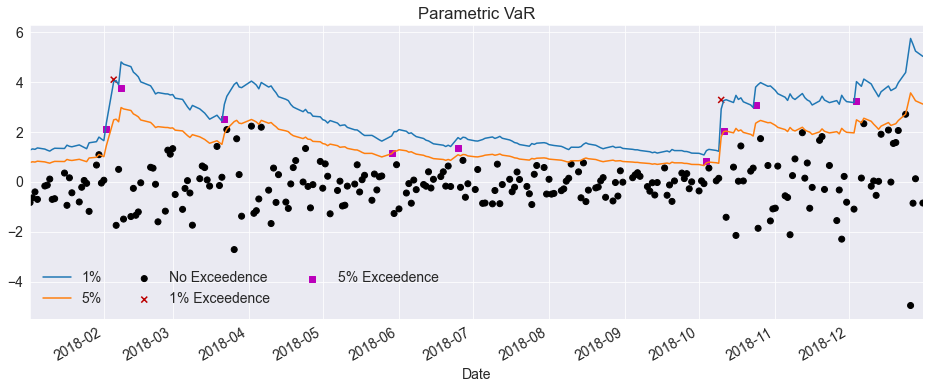

In [19]:
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns['2018':].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)


#o 5% é mais arriscado, com vários valores escedidos

# VaR histórico: usa a própria série

In [20]:
std_rets = (returns[:'2017'] - res.params['mu']) / res.conditional_volatility
std_rets

Date
1999-01-05    0.968750
1999-01-06    1.606148
1999-01-07   -0.178051
1999-01-08    0.268591
1999-01-11   -0.706152
                ...   
2018-12-24         NaN
2018-12-26         NaN
2018-12-27         NaN
2018-12-28         NaN
2018-12-31         NaN
Length: 5030, dtype: float64

In [21]:
std_rets = std_rets.dropna()
q = std_rets.quantile([.01, .05]) #o valor que separa em quantil
q

0.01   -2.668272
0.05   -1.723352
dtype: float64

In [22]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)

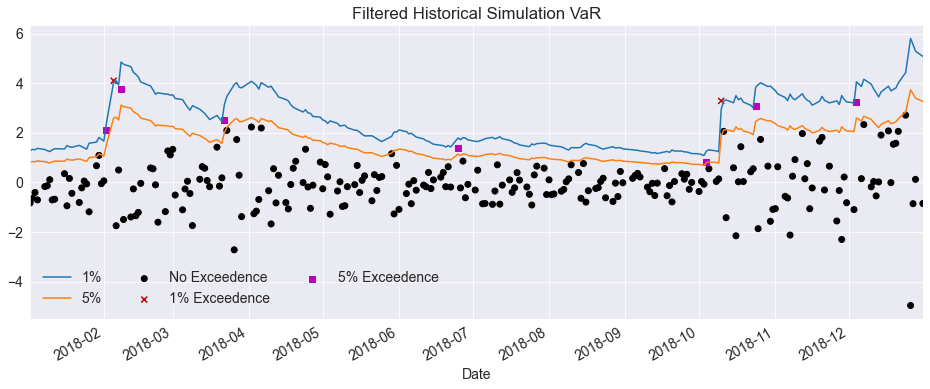

In [23]:
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns['2018':].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Filtered Historical Simulation VaR')
leg = ax.legend(frameon=False, ncol=3)